# Handwriting recognition


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

## Data import and visualization


Import the MNIST train dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database))


In [3]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt("./mnist_train_small.csv", delimiter=",")
data.shape

(20000, 785)

Store the data in a matrix and the labels in a vector.

**REMARK**: in this lab we will work with features/classes on rows and samples on columns.


In [4]:
labels = data[:, 0]
x_data = data[:, 1:].transpose() / 255
labels.shape, x_data.shape

((20000,), (784, 20000))

Visualize the first 30 pictures with the corresponding labels


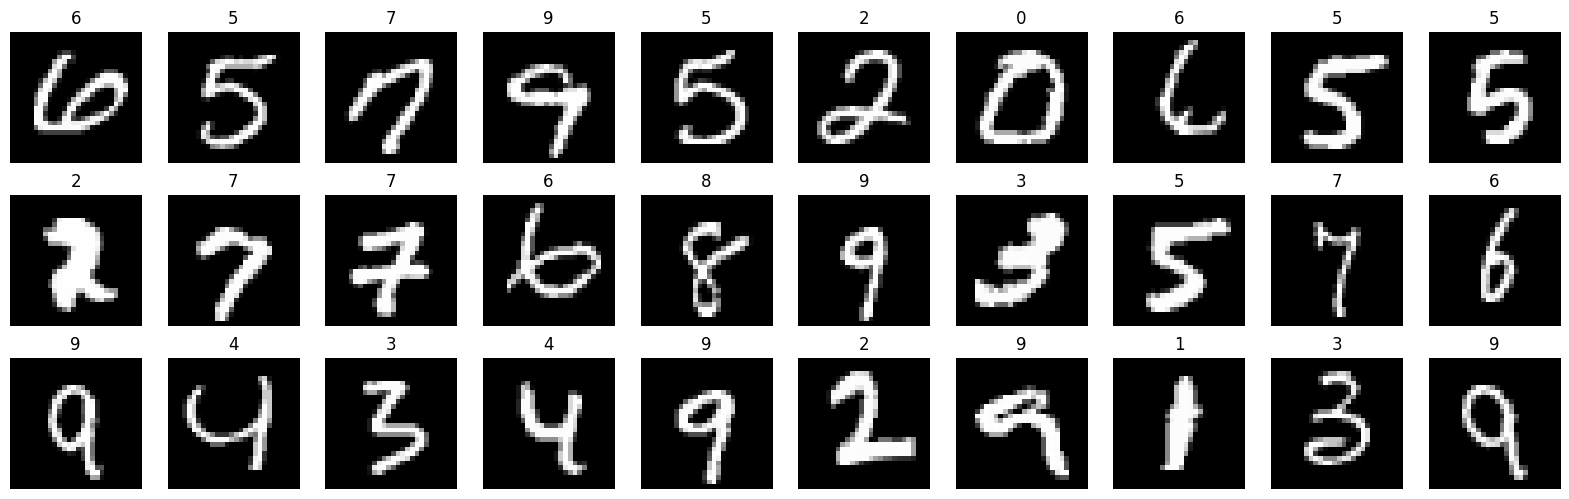

In [5]:
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 6))
axs = axs.reshape((-1,))
for i in range(30):
    image_i = x_data[:, i].reshape((28, 28))
    axs[i].imshow(image_i, cmap="gray")
    axs[i].set_title(int(labels[i]))
    axs[i].axis("off")

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.


In [6]:
y_data = np.zeros((10, 20000))
for i in range(10):
    y_data[i, labels == i] = 1

Check that the matrix has exactly one element "1" in each column.


In [7]:
row_sums = np.sum(y_data, axis=0)
row_sums.min(), row_sums.max()

(np.float64(1.0), np.float64(1.0))

## ANN training

Write a function to initialize the parameters (with Glorot Normal initialization) and a function implementing a feedforward ANN with tanh activation function.

To the last layer of the ANN, apply a _soft-max_ layer. If $z_1, \dots, z_n$ are the activations of the last layer neurons, the soft-max layer produces $\hat{z}_1, \dots, \hat{z}_n$, defined as

$$
\hat{z}_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$

In this manner the outputs of the ANN satisfy by construction:

- $\hat{z}_i \in [0,1]$
- $\sum_{j=1}^n \hat{z}_j = 1$

Therefore, they can be intepreted as probabilities.

When the ANN will be trained, we will take the digit corresponding the the hightest proabability as prediction of the model.


In [29]:
def initialize_params(layers_size):
    np.random.seed(0)  # for reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i]) * np.sqrt(
            2 / (layers_size[i + 1] + layers_size[i])
        )
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params


activation = jnp.tanh


def ANN(x, params):
    layer = x
    num_layers = int(len(params) / 2 + 1)
    weights = params[0::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        layer = jnp.dot(weights[i], layer) - biases[i]
        if i < num_layers - 2:
            layer = activation(layer)
    
    # Exponentials of large numbers can grow extremely quickly, 
    # leading to numerical overflow when the input is large.
    # The practical implementation of softmax is non-trivial
    # thus, it is importarnt to use the jax function
    layer = jax.nn.softmax(layer, axis=0)
    return layer

Test the ANN and check that the above properties are satisfied.


In [33]:
# check the minimum and maximum of the predictoin for `x_data` if between 0 and 1
# check that the sum of the outputs (for each input) is 1

params = initialize_params([784, 20, 10])
predictions = ANN(x_data[:,0], params)

print(predictions.shape)

predictions.min(), predictions.max(), predictions.sum(axis=0).min(), predictions.sum(axis=0).max()

(10, 20)


(Array(0.01768928, dtype=float32),
 Array(0.34833166, dtype=float32),
 Array(0.9999998, dtype=float32),
 Array(1.0000001, dtype=float32))

Implement the following metrics:

- mean square error
- cross entropy
- accuracy (fraction of samples correctly classified)


In [ ]:
def MSE(x, y, params):
    y_pred = ANN(x, params)
    return jnp.mean((y - y_pred) ** 2)

def cross_entropy(x, y, params):
    y_pred = ANN(x, params)
    return -jnp.mean(jnp.sum(y * jnp.log(y_pred + 1e-10), axis=0))


def accuracy(x, y, params):
    y_pred = ANN(x, params)
    y_pred_labels = jnp.argmax(y_pred, axis=0)
    y_true_labels = jnp.argmax(y, axis=0)
    return jnp.mean(y_pred_labels == y_true_labels)


print(f"MSE:       {MSE(x_data, y_data, params):f}")
print(f"X entropy: {cross_entropy(x_data, y_data, params):f}")
print(f"accuracy:  {accuracy(x_data, y_data, params):f}")

MSE:       0.091103
X entropy: 2.361587
accuracy:  0.110050


Put 10000 images in the training set and 10000 images in the validation set.


In [44]:
n_train = 10000
n_valid = 10000

idxs = np.random.permutation(20000)
x_data = x_data[:, idxs]
y_data = y_data[:, idxs]

x_train = x_data[:, :n_train]
y_train = y_data[:, :n_train]
x_valid = x_data[:, -n_valid:]
y_valid = y_data[:, -n_valid:]

Run this cell. We will use it later.


In [48]:
from IPython import display


class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, figsize=(16, 8))
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs.clear()
            epochs = np.arange(1, len(history_train_Xen) + 1)
            self.axs.loglog(epochs, history_train_Xen, label="train_Xen")
            self.axs.loglog(epochs, history_valid_Xen, label="valid_Xen")
            self.axs.loglog(epochs, history_valid_MSE, label="valid_MSE")
            self.axs.loglog(epochs, history_valid_acc, label="valid_acc")

            self.axs.legend()
            self.axs.set_title(
                f"epoch {self.epoch+1} - accuracy {100 * history_valid_acc[-1]:.1f}%"
            )

Train an ANN-based classifier with two hidden layers with 50 neurons each.
Use 500 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta = 10^{-7}$ and fixed learning rate $\lambda = 0.002$. Use minibatches with batch size of 1000.

Use the cross-entropy loss to drive the training.
To monitor training, store every 10 training epochs the following metrics in the following lists:

- `history_train_Xen`: cross-entropy (training set)
- `history_valid_Xen`: cross-entropy (validation set)
- `history_valid_MSE`: MSE (validation set)
- `history_valid_acc`: accuracy (validation set)


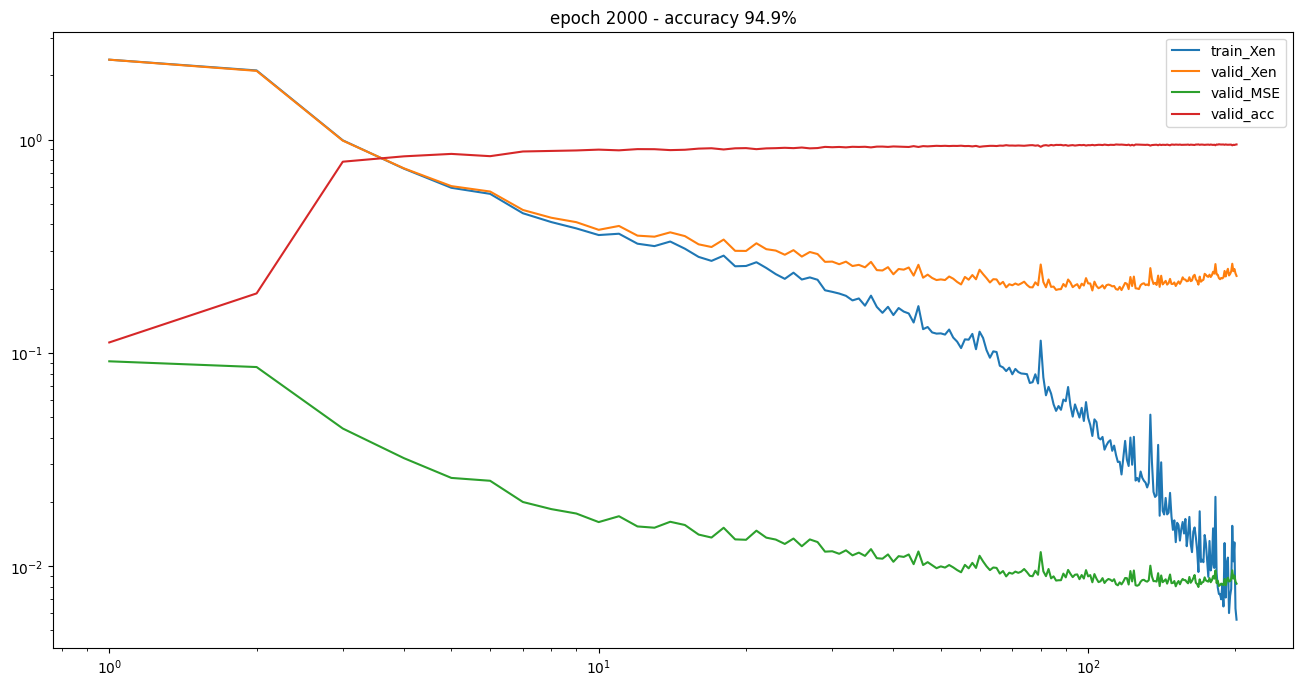

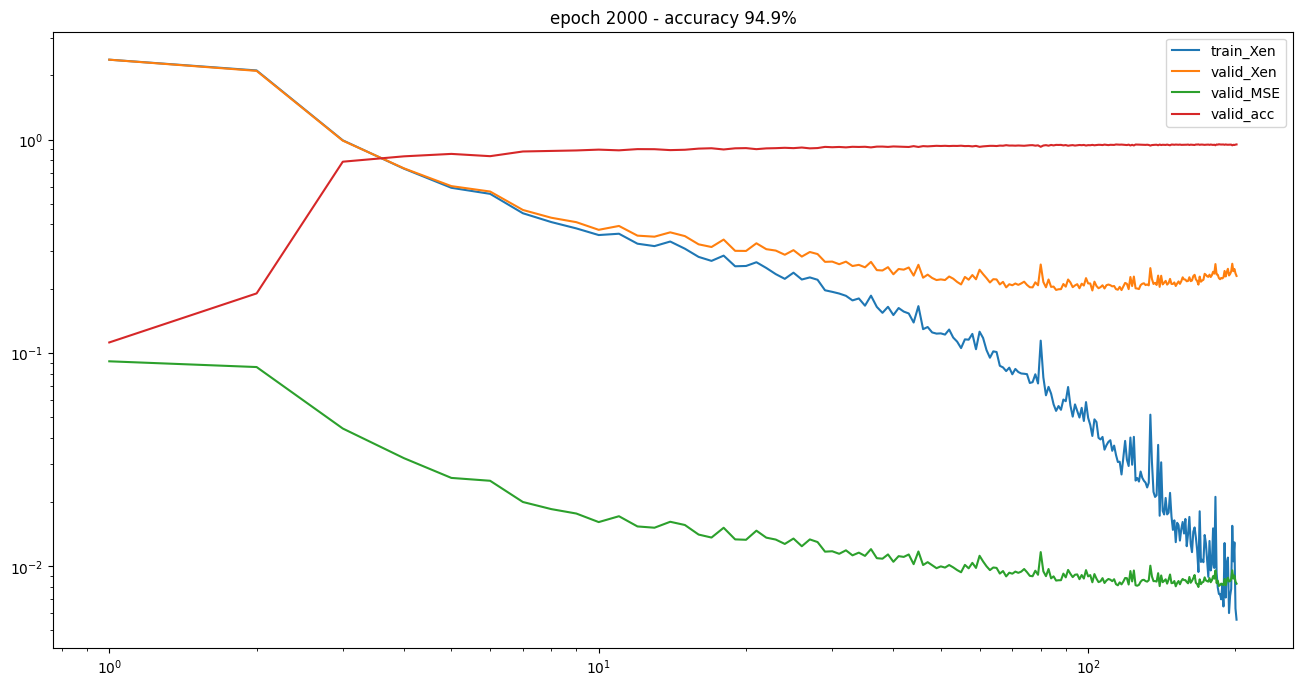

In [49]:
# Hyperparameters
layers_size = [784, 50, 50, 10]
# Training options
num_epochs = 2000
batch_size = 100
learning_rate = 2e-3
decay_rate = 0.9
delta = 1e-7
########################################

params = initialize_params(layers_size)

grad = jax.grad(cross_entropy, argnums=2)
grad_jit = jax.jit(grad)

cross_entropy_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()


def dump():
    history_train_Xen.append(cross_entropy_jit(x_train, y_train, params))
    history_valid_Xen.append(cross_entropy_jit(x_valid, y_valid, params))
    history_valid_MSE.append(MSE_jit(x_valid, y_valid, params))
    history_valid_acc.append(accuracy_jit(x_valid, y_valid, params))


dump()
cb = Callback(refresh_rate=50)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
    # learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
    idxs = np.random.choice(n_train, batch_size)
    grads = grad_jit(x_train[:, idxs], y_train[:, idxs], params)

    for i in range(len(params)):
        cumulated_square_grad[i] = (
            decay_rate * cumulated_square_grad[i]
            + (1 - decay_rate) * grads[i] * grads[i]
        )
        params[i] -= (
            learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]
        )

    if epoch % 10 == 0:
        dump()

    cb(epoch)
cb.draw()

## Testing


Load the dataset `sample_data/mnist_test.csv` and compute the accuracy of the classifier on this dataset.


In [ ]:
data_test = np.genfromtxt("./mnist_test.csv", delimiter=",")
print(data_test.shape)

labels_test = data_test[:, 0]
x_test = data_test[:, 1:].transpose() / 255
y_test = np.zeros((10, x_test.shape[1]))
for i in range(10):
    y_test[i, labels_test == i] = 1
x_test.shape, y_test.shape

((784, 10000), (10, 10000))

In [54]:
loss_test = cross_entropy_jit(x_test, y_test, params)
acc_test = accuracy_jit(x_test, y_test, params)
mse_test = MSE_jit(x_test, y_test, params)

# check metrics on test dataset
print("Test set:")
print(f"MSE:       {mse_test:f}")
print(f"X entropy: {loss_test:f}")
print(f"accuracy:  {acc_test:f}")

Test set:
MSE:       0.007307
X entropy: 0.194785
accuracy:  0.955800


Use the following script to visualize the predictions on a bunch of test images.


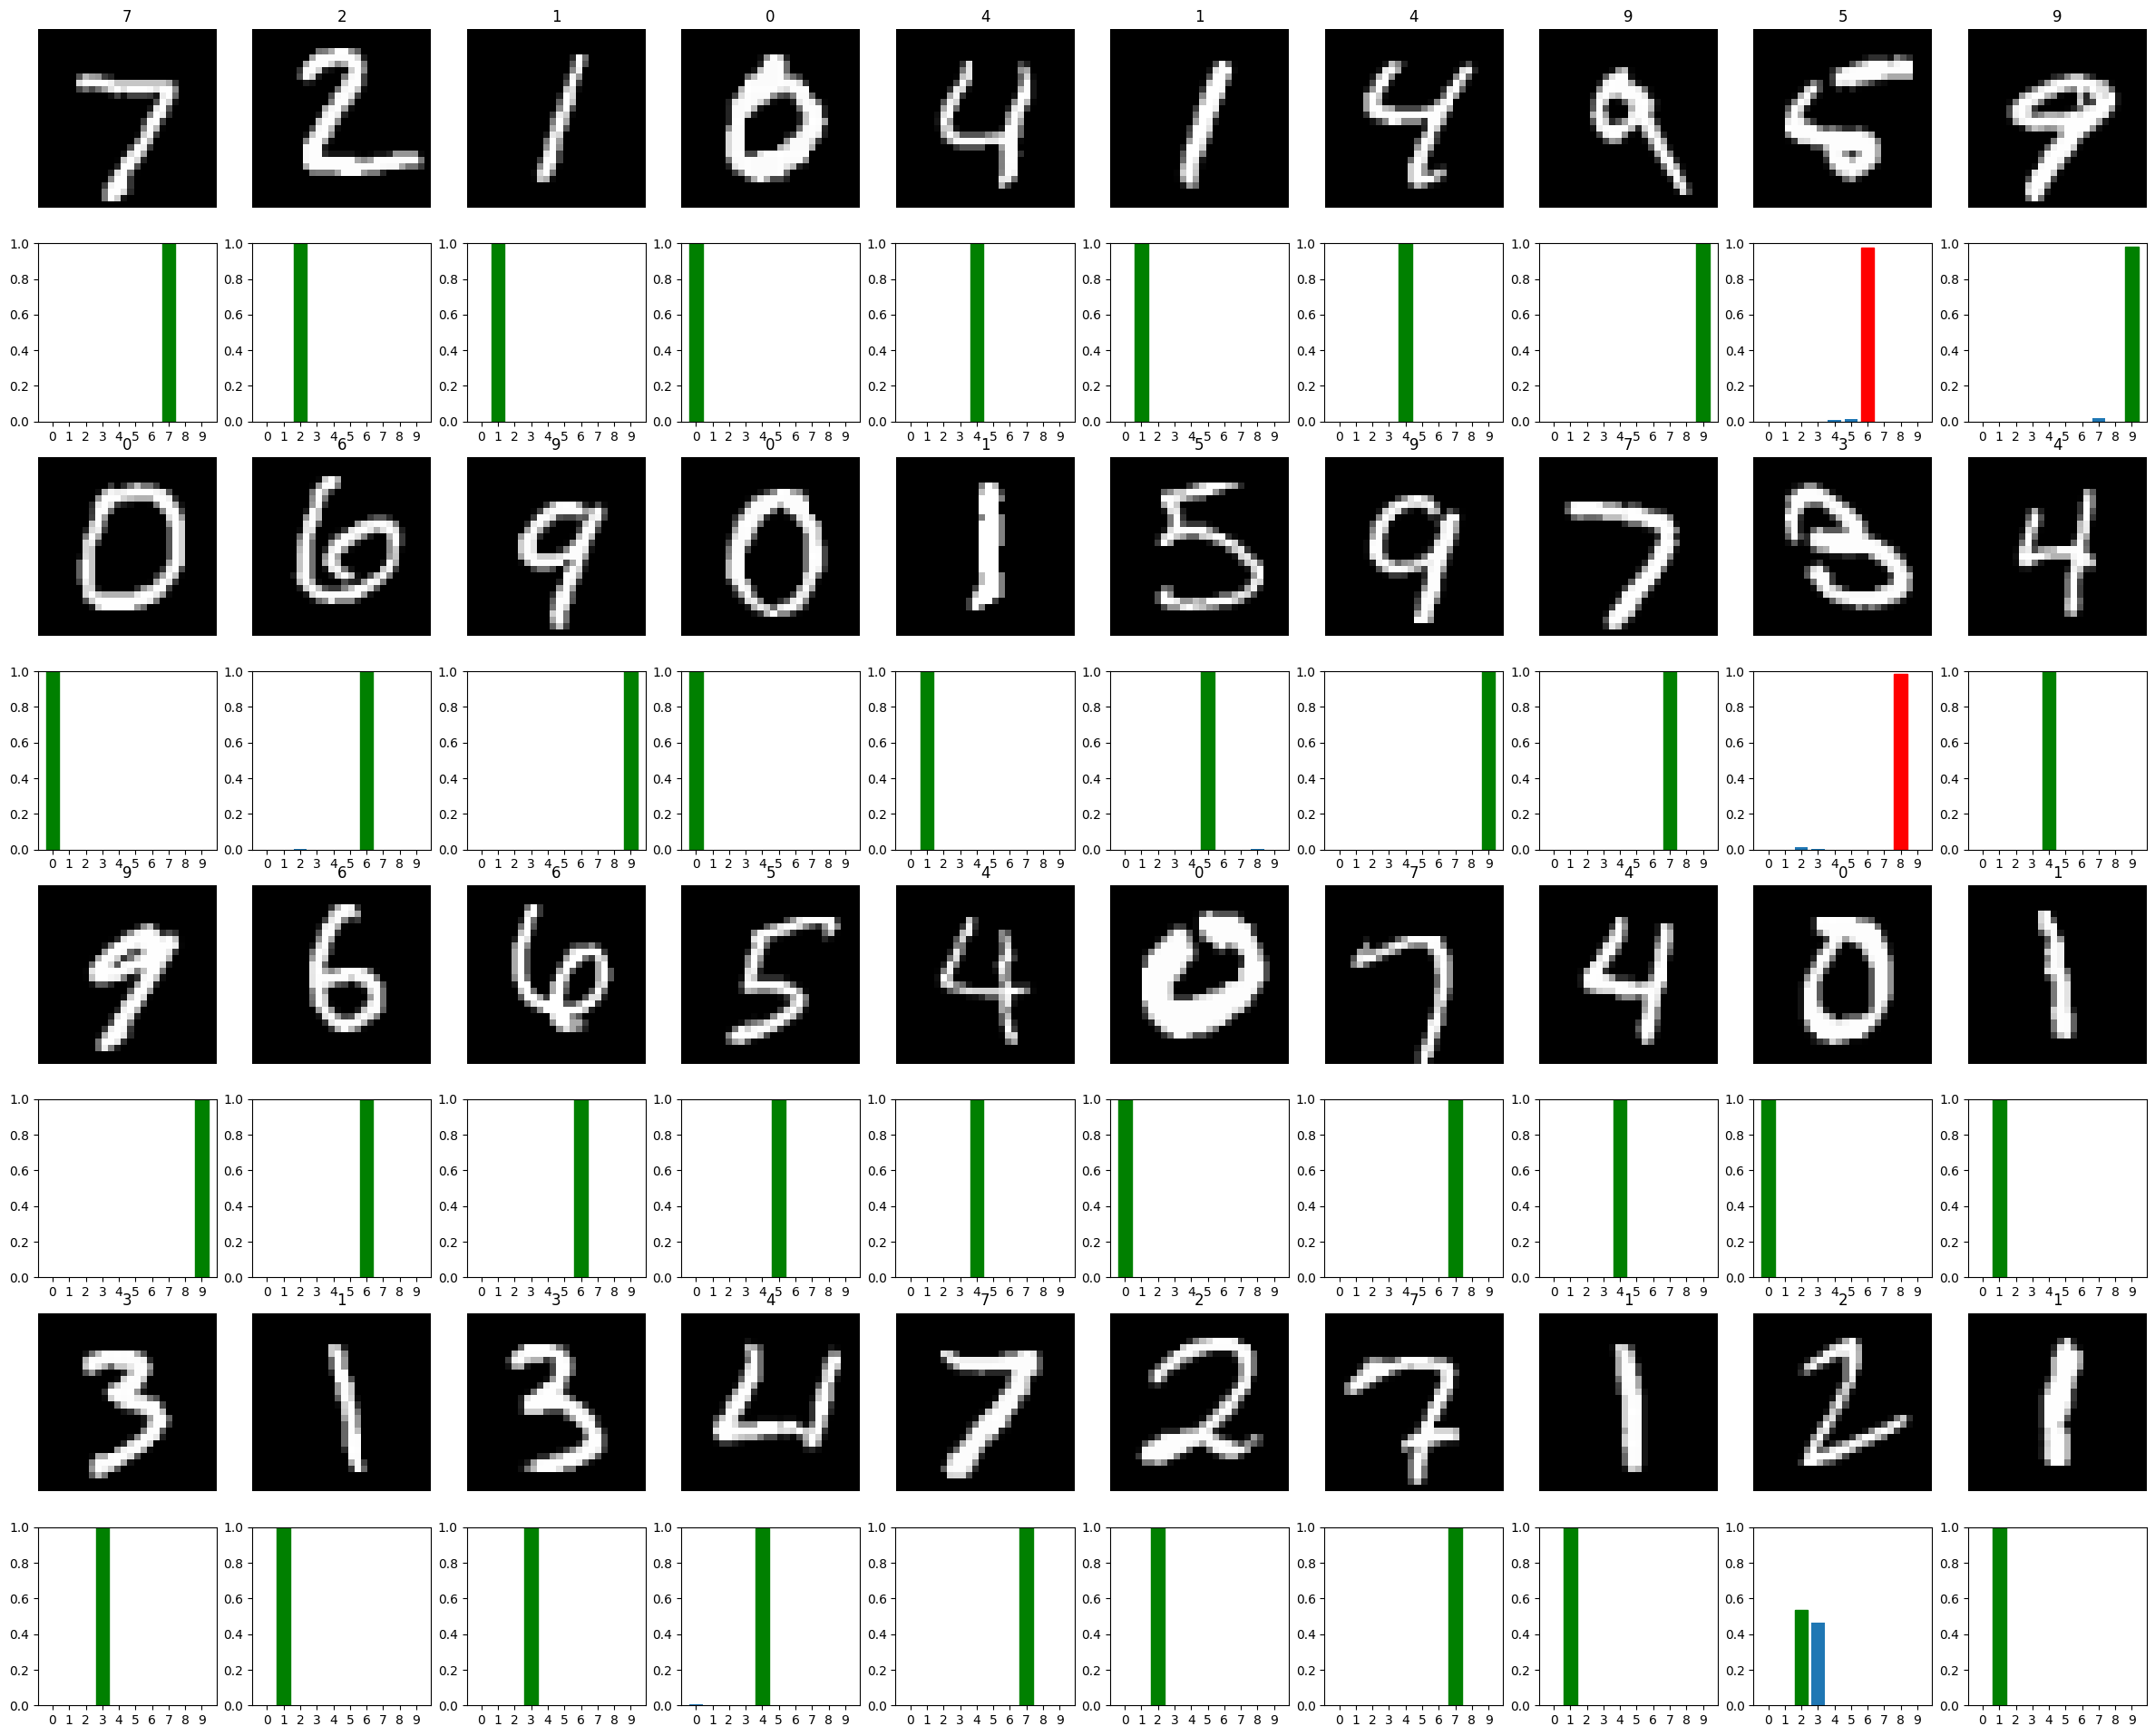

In [55]:
import math

n_images = 40
offset = 0

images_per_row = 10
y_predicted = ANN(x_test[:, offset : offset + n_images], params)


def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0, 1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
        color = "green"
    else:
        color = "red"
    myplot[label_predicted].set_color(color)



n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize=(3 * images_per_row, 3 * n_rows))
row = 0
col = 0
for i in range(n_images):
    axs[2 * row, col].imshow(x_test[:, offset + i].reshape((28, 28)), cmap="gray")
    axs[2 * row, col].set_title(int(labels_test[offset + i]))
    axs[2 * row, col].axis("off")

    draw_bars(axs[2 * row + 1, col], y_predicted[:, i], labels_test[offset + i])

    col += 1
    if col == images_per_row:
        col = 0
        row += 1

# Adversarial attacks

You have trained your classifier. Cool, isn't it? Let us now try to fool it.

Consider the last image of the training set. Visualize it and visualize the associated predictions of the classifier.


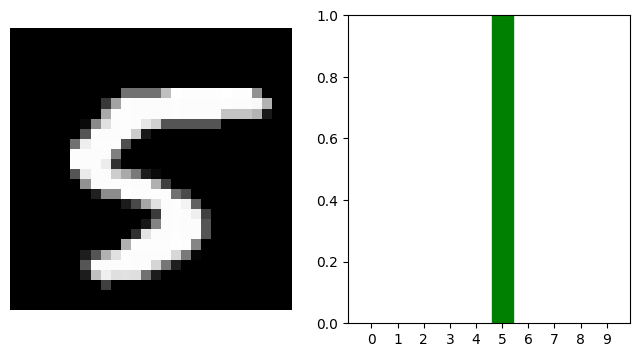

In [56]:
x = x_data[:, -1][:, None]
y = y_data[:, -1][:, None]
label = np.argmax(y)

_, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(x.reshape((28, 28)), cmap="gray")
axs[0].axis("off")

y_pred = ANN(x, params)

draw_bars(axs[1], y_pred[:, 0], label)

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake.
See e.g. [this article](https://www.wired.com/story/tesla-speed-up-adversarial-example-mgm-breach-ransomware/)

To hack the classifier, compute the gradient of cross entropy loss funcion with respect to the input (not to the parameters!). Then, superimpose a multiple of the gradient to the original image. See e.g. [this article](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm).

Visualize the original and the hacked images and the corresponding prediction of the classifier.


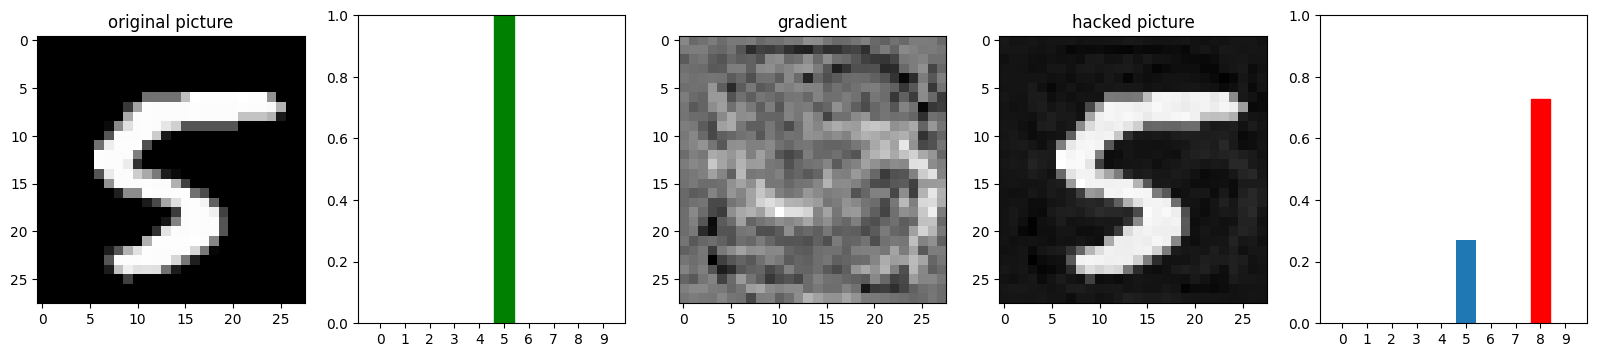

In [62]:
gradient = jax.grad(cross_entropy, argnums=0)
gradient = gradient(x, y, params)
x_updated = x + 5000*gradient
y_updated = ANN(x_updated, params)

_, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(x.reshape((28, 28)), cmap="gray")
axs[0].set_title("original picture")
draw_bars(axs[1], y_pred[:, 0], label)
axs[2].imshow(gradient.reshape((28, 28)), cmap="gray")
axs[2].set_title("gradient")
axs[3].imshow(x_updated.reshape((28, 28)), cmap="gray")
axs[3].set_title("hacked picture")
draw_bars(axs[4], y_updated[:, 0], label)